In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools as it

In [95]:
import dill
dill.dump_session('notebook_env.db')

NotImplementedError: numpy() is only available when eager execution is enabled.

In [3]:
(x_train0, y_train0), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train = x_train0[:50000]
y_train = y_train0[:50000]
x_hold = x_train0[50000:]
y_hold = y_train0[50000:]

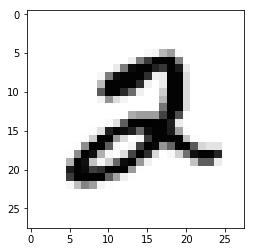

In [5]:
y_train.shape
plt.imshow(x_train[5], cmap='Greys')

In [6]:
x_train_flat = np.array([x.reshape((784)) for x in x_train])
x_test_flat = np.array([x.reshape((784))for x in x_test])
x_train_flat.shape

#"Unrolled" MNIST array is numbered left to right, top to bottom., so first entry of each unrolled vector is top-left pixel

(50000, 784)

In [8]:
def GF00(j):
    return(np.exp(-2*(np.floor(j/28)-13.5)**2-(j%28 - 13.5)**2))

#Handle r=0 case specially

In [19]:
GF = np.zeros((417,784))

GF[0,] = [GF00(x) for x in np.arange(784)] 
for i in range(1,32*13+1):
    for j in range(784):
        r = (np.floor((i-1)/32)+1)
        t = (i-1)%32*(2*np.pi/32)
        u = 27-np.floor(j/28)
        v = j%28
        GF[i,j] = np.exp((-(v-13.5-r*math.cos(t))**2-(u-13.5-r*math.sin(t))**2)/((.02*r+.5)))

In [20]:
x_train_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_train_flat)))
x_test_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_test_flat)))
x_train_rot_nonorm.shape

#Now normalize each image by dividing image values by max pixel intensity. 

x_train_rot = np.transpose(np.transpose(x_train_rot_nonorm)/np.amax(x_train_rot_nonorm,axis=1))
x_test_rot = np.transpose(np.transpose(x_test_rot_nonorm)/np.amax(x_test_rot_nonorm,axis=1))

In [11]:
#Check normalization works
print(max(x_test_rot[55]), max(x_train_rot[66]))

1.0 1.0


In [14]:
def rot_plot(image):
    dum = np.array(range(416))
    rad = 1.3*(np.floor(dum/32)+1)
    theta = (dum)%32*(2*np.pi/32)
    x_coord = np.concatenate(([0],np.multiply(rad,np.cos(theta))))
    y_coord = np.concatenate(([0],np.multiply(rad, np.sin(theta))))
    
    plt.figure(figsize=(10,10))
    plt.scatter(x = x_coord, y = y_coord, c = image,cmap="Greys")
    plt.show()

In [26]:
x_train_rot.shape

(50000, 417)

Number is 2


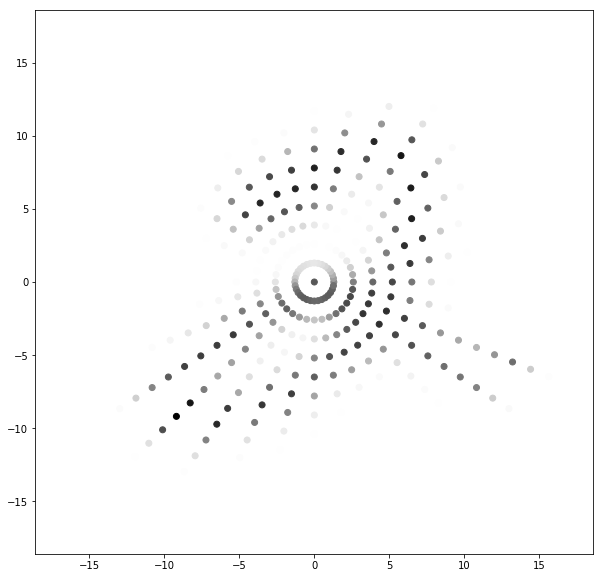

In [21]:
print("Number is",y_train[5])
rot_plot(x_train_rot[5])

In [31]:
def firstdeg(x_train_rot):
    dummy = np.empty(14)
    
    dummy[0] = x_train_rot[0]
    for i in range(13):
        dummy[i+1] = np.sum(x_train_rot[(32*i+1):(32*i+33)])/32 #32*i+1 selects the radius
    return(dummy)
#FRANK!!! REMEMBER INDEXING [1:3] ONLY SELECTS ENTRIES 1 AND 2!!!

In [32]:
def secdeg(x_train_rot):
    dummy = [x_train_rot[0]**2]
    
    #Here calculate the terms involving center point
    for r in range(13):
        dummy.append(np.sum(x_train_rot[0]*x_train_rot[(r*32+1):(r*32+33)])/32)
        
    #Then, calculate everything else
    for i in range(13):
        for j in range(13):
            for k in range(9):
                if k == 0 and i<j: #don't double count these special pairs
                    continue
                    
                total = 0
                
                for s in range(32):
                    total += x_train_rot[i*32+1+s]*x_train_rot[j*32+1+(2*k+s)%32]
                    
                dummy.append(total/32)
    
    return(np.array(dummy))

In [75]:
# def secdeg_mat(x_train_rot):
#     dummy = [x_train_rot[:,0]**2]
    
#     #Here calculate the terms involving center point
#     for r in range(10):
#         np.c_[dummy,(np.sum(np.transpose(np.transpose(x_train_rot[:,(r*32+1):(r*32+33)])*x_train_rot[:,0]),axis=1)/32)]
        
#     #Then, calculate everything else
#     for i in range(10):
#         for j in range(10):
#             for k in range(17):
#                 if k == 0 and i<j: #don't double count these special pairs
#                     continue
                    
#                 total = 0
                
#                 for s in range(32):
#                     total += x_train_rot[i*32+1+s]*x_train_rot[j*32+1+(k+s)%32]
                    
#                 dummy.append(total/32)
    
#     return(np.array(dummy))

In [128]:
# def thirdeg(x_train_rot):
#     #Only calculate triangles with vertices on same radius, angles.
#     #Fixing the minimal angle, there is a bijection (?):
#     dummy = []
#     for r in range(6):
#         for i in range(1,6):
#             for j in range(16):
#                 if j < i or j > (16 - 2*i):
#                     continue
#                 total = 0
#                 for s in range(32):
#                     total += x_train_rot[32*r+1+s]*x_train_rot[32*r+1+(2*i+s)%32]*x_train_rot[32*r+1+(2*(i+j)+s)%32]
                
#                 dummy.append(total/32)
                
#     return(np.array(dummy))
            

In [24]:
# def rot_features(x_train_rot):
#     return(np.concatenate([firstdeg(x_train_rot),secdeg(x_train_rot),thirdeg(x_train_rot)]))
def rot_features(x_train_rot):
    return(np.concatenate([firstdeg(x_train_rot),secdeg(x_train_rot)]))

In [33]:
print(firstdeg(x_train_rot[0]).shape)
print(secdeg(x_train_rot[0]).shape)
#firstdeg(x_train_rot[0])

(14,)
(1457,)


In [34]:
print(max(rot_features(x_train_rot[7])),max(firstdeg(x_train_rot[7])),\
      max(secdeg(x_train_rot[7])))

0.9402852613522679 0.9402852613522679 0.8841363727163026


In [35]:
x_train_features = np.array([rot_features(x) for x in x_train_rot])
x_test_features = np.array([rot_features(x) for x in x_test_rot])

In [36]:
x_train_features.shape

(50000, 1471)

In [37]:
model = keras.Sequential([
    keras.layers.Dense(200, input_shape = (1471,), activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Seems to be very sensitive to initialization:
#First try, took maybe 10 runs of 5 epochs to get .83
#Second try, got stuck at local minima with .5 accuracy
#Third try, first run got one a good path, achieved .9 accuracy by epoch 15
#After normazliation, optimization seems to run muuch smoother, e very run so far gets to above .9 accuracy

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
model.fit(x_train_features, y_train, verbose=1, epochs=15)

Epoch 1/10
50000/50000 [==============================] - 8s 152us/sample - loss: 0.6110 - acc: 0.8225
Epoch 2/10
50000/50000 [==============================] - 8s 165us/sample - loss: 0.3261 - acc: 0.9043
Epoch 3/10
50000/50000 [==============================] - 8s 163us/sample - loss: 0.2646 - acc: 0.9215
Epoch 4/10
50000/50000 [==============================] - 8s 154us/sample - loss: 0.2336 - acc: 0.9292
Epoch 5/10
50000/50000 [==============================] - 7s 146us/sample - loss: 0.2146 - acc: 0.9343
Epoch 6/10
50000/50000 [==============================] - 7s 145us/sample - loss: 0.1929 - acc: 0.9418
Epoch 7/10
50000/50000 [==============================] - 8s 168us/sample - loss: 0.1823 - acc: 0.9440
Epoch 8/10
50000/50000 [==============================] - 8s 154us/sample - loss: 0.1731 - acc: 0.9477
Epoch 9/10
50000/50000 [==============================] - 7s 139us/sample - loss: 0.1607 - acc: 0.9501
Epoch 10/10
50000/50000 [==============================] - 6s 124us/sampl

In [51]:
model.evaluate(x_test_features, y_test)

10000/10000 [==============================] - 0s 36us/sample - loss: 0.1713 - acc: 0.9470


[0.17130417791232466, 0.947]

In [158]:
#Looking at predictions made by trained model
predictions1 = np.argmax(model.predict(x_test_features),axis=1)
predictions = np.column_stack((predictions1,y_test))
print(predictions[1:10,])

[[2 2]
 [1 1]
 [0 0]
 [4 4]
 [1 1]
 [4 4]
 [9 9]
 [6 5]
 [9 9]]


In [248]:
# #Now, we look at a model that considers up to second order features:

# x_train_secorder = x_train_features[:,0:611]
# x_test_secorder = x_test_features[:,0:611]

# model_secorder = keras.Sequential([
#     keras.layers.Dense(200, input_shape = (611,), activation=tf.nn.relu),
#     keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

# model_secorder.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model_secorder.fit(x_train_secorder, y_train, epochs=30)

Epoch 1/15
60000/60000 [==============================] - 5s 91us/sample - loss: 0.6869 - acc: 0.7919
Epoch 2/15
60000/60000 [==============================] - 5s 84us/sample - loss: 0.3901 - acc: 0.8824
Epoch 3/15
60000/60000 [==============================] - 5s 87us/sample - loss: 0.3224 - acc: 0.9002
Epoch 4/15
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2887 - acc: 0.9111
Epoch 5/15
60000/60000 [==============================] - 4s 74us/sample - loss: 0.2616 - acc: 0.9180
Epoch 6/15
60000/60000 [==============================] - 5s 82us/sample - loss: 0.2448 - acc: 0.9229
Epoch 7/15
60000/60000 [==============================] - 5s 86us/sample - loss: 0.2288 - acc: 0.9276
Epoch 8/15
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2169 - acc: 0.9320
Epoch 9/15
60000/60000 [==============================] - 6s 93us/sample - loss: 0.2070 - acc: 0.9342
Epoch 10/15
60000/60000 [==============================] - 5s 90us/sample - loss: 

In [251]:
# model_secorder.evaluate(x_test_secorder, y_test)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.1680 - acc: 0.9513


[0.16803432475328445, 0.9513]

In [56]:
#Now want to show features are invariant under rotation (technically by 2pi/32)
#Creating the rotation matrix
PermBlock = np.empty((32,32))
for i in range(32):
    for j in range(32):
        if (i+1)%32 == j:
            PermBlock[i,j] = 1
        else:
            PermBlock[i,j] = 0
            
PermMat1 = np.kron(np.eye(13),PermBlock)
PermMat2 = np.vstack((np.zeros((1,13*32)),PermMat1))
PermMat_FirstCol = np.zeros((13*32+1,1))
PermMat_FirstCol[0] = 1
PermMat = np.hstack((PermMat_FirstCol,PermMat2))
print(PermMat.shape)
PermMat

(417, 417)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
#Show that features are invariant under rotation by 2*pi/32. Will do it on test set, since calculating features is long.
#As this generates group, features invariant under entire action
test_rotdiff = np.array([rot_features(x) for x in np.transpose(np.matmul(PermMat,np.transpose(x_test_rot)))])
np.amax(np.abs(x_test_features-test_rotdiff))

KeyboardInterrupt: 

In [50]:
#Confirm for an even more extreme rotation of 13*2*pi/32.

x_test_rot100 = np.transpose(np.matmul(np.linalg.matrix_power(PermMat,13),np.transpose(x_test_rot[:100])))
test_rotdiff100 = np.array([rot_features(x) for x in x_test_rot100])
np.amax(np.abs(x_test_features[:100]-test_rotdiff100))

4.440892098500626e-16

In [47]:
#Now want to train a CNN:

#First, prepare the data for CNN
x_test_CNN = x_test.reshape(10000,28,28,1)
x_train_CNN = x_train.reshape(50000,28,28,1)
x_hold_CNN = x_hold.reshape(10000,28,28,1)
x_test_CNN = x_test_CNN.astype('float32')
x_train_CNN = x_train_CNN.astype('float32')
x_test_CNN = x_test_CNN/255
x_train_CNN = x_train_CNN/255
x_hold_CNN = x_hold_CNN/255

In [168]:
x_train_CNN.shape

(50000, 28, 28, 1)

In [169]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 

Using TensorFlow backend.


In [171]:
# Three steps to create a CNN
# 1. Convolution
# 2. Activation
# 3. Pooling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model_CNN = Sequential()

model_CNN.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(32, (3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Conv2D(64,(3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(64, (3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Flatten())

# Fully connected layer
model_CNN.add(Dense(512))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(10))

model_CNN.add(Activation('softmax'))

model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [172]:
model_CNN.fit(x_train_CNN, y_train, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
50000/50000 [==============================] - 121s 2ms/step - loss: 0.0935 - acc: 0.9707
Epoch 2/5
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0418 - acc: 0.9872
Epoch 3/5
50000/50000 [==============================] - 120s 2ms/step - loss: 0.0354 - acc: 0.9887
Epoch 4/5
50000/50000 [==============================] - 119s 2ms/step - loss: 0.0284 - acc: 0.9910
Epoch 5/5
50000/50000 [==============================] - 119s 2ms/step - loss: 0.0247 - acc: 0.9919 1s - loss


In [173]:
model_CNN.evaluate(x_test_CNN, y_test)

10000/10000 [==============================] - 10s 984us/step


[0.02853153463031631, 0.9911]

In [48]:
#Now, we'll evaluate all models so far on rotated test set
#Generate rotated dataset first:
x_hold_rotCNN = []

for i in range(10000):
    x_hold_rotCNN.append((tf.contrib.keras.preprocessing.image.random_rotation(x_hold_CNN[i], rg = 90, row_axis=0, col_axis=1, channel_axis=2)))

x_hold_rotCNN = np.array(x_hold_rotCNN)

In [77]:
import cv2 

In [69]:
x_test.shape

(10000, 28, 28)

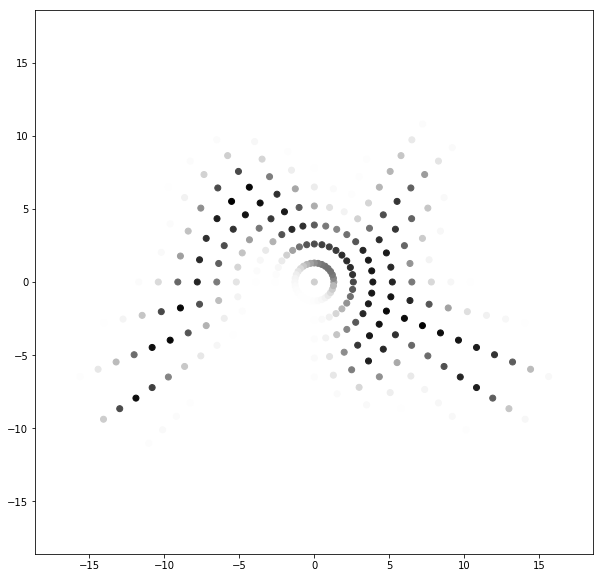

In [90]:
M = cv2.getRotationMatrix2D((28 / 2, 28 / 2), 67, 1) 
res = cv2.warpAffine(x_hold[100], M, (28, 28)) 
res = np.matmul(GF,res.reshape(784))
res = res/np.amax(res)
rot_plot(res)

In [49]:
#Generate features
x_hold_rot_raw = x_hold_rotCNN.reshape(10000,28,28)
x_hold_rot_raw = np.array([x.reshape((784))for x in x_hold_rot_raw])
x_hold_rot_raw = np.transpose(np.matmul(GF, np.transpose(x_hold_rot_raw)))
x_hold_rot_raw = np.transpose(np.transpose(x_hold_rot_raw)/np.amax(x_hold_rot_raw,axis=1))
x_hold_rot_features = np.array([rot_features(x) for x in x_hold_rot_raw])

In [52]:
x_hold_rotCNN.shape

(10000, 28, 28, 1)

In [227]:
def diffrot(i):
    return(np.amax(rot_features(x_test_rotated_raw[i])-rot_features(x_test_rot[i])))

In [230]:
diffrot(400)

0.31698512721059324

7


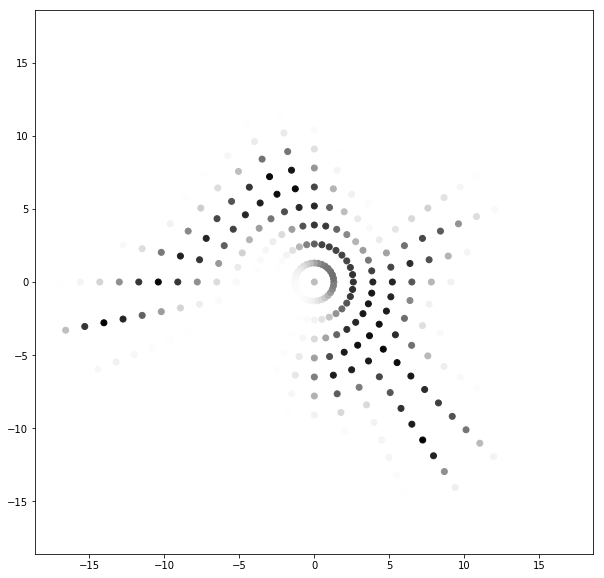

In [55]:
print(y_hold[100])
rot_plot(x_hold_rot_raw[100])

Number is  6


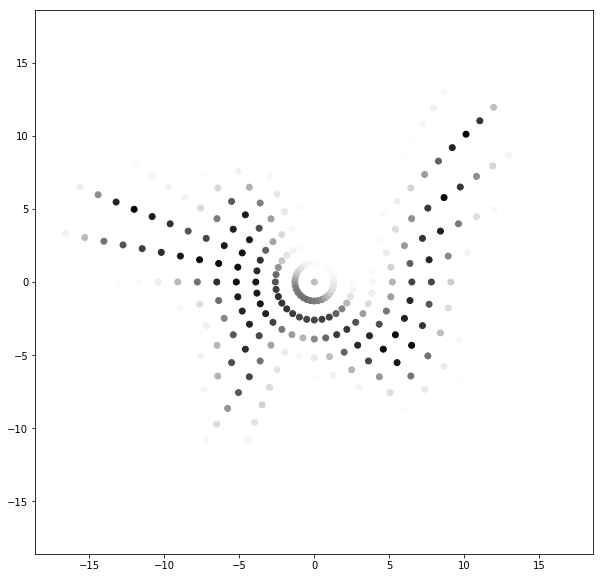

In [57]:
print("Number is ",y_test[100])
rot_plot(np.matmul(np.linalg.matrix_power(PermMat,13),x_hold_rot_raw[100]))

Number is  6


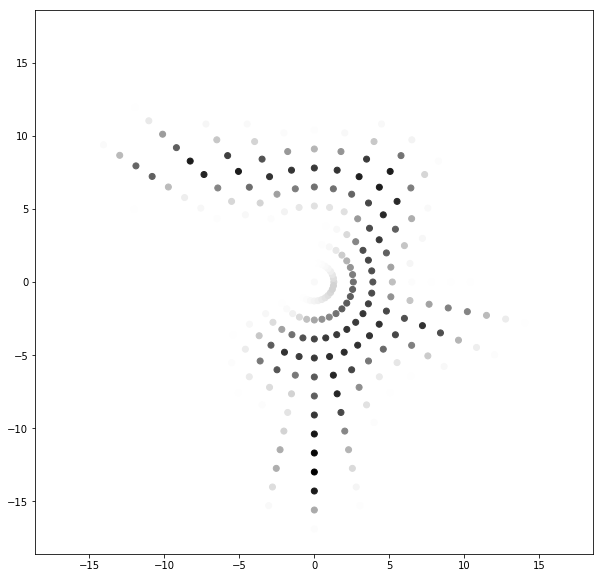

In [61]:
print("Number is ",y_test[100])
rot_plot(x_hold_rotTest[100])

In [60]:
x_hold_rotTest = np.array([x.reshape((784))for x in x_hold])
x_hold_rotTest = np.transpose(np.matmul(GF, np.transpose(x_hold_rotTest)))
x_hold_rotTest = np.transpose(np.transpose(x_hold_rotTest)/np.amax(x_hold_rotTest,axis=1))

In [92]:
#So rotated and original image give the same
print(np.amax(rot_features(np.matmul(np.linalg.matrix_power(PermMat,13),x_hold_rot_raw[100])) - rot_features(x_hold_rot_raw[100])))

#Now lets compare to original
print(np.amax(rot_features(x_hold_rot_raw[100])-rot_features(x_hold_rotTest[100])))

#Now compare cv rotated
print(np.amax(rot_features(x_hold_rot_raw[100])-rot_features(res)))


1.6653345369377348e-16
0.3197671209969095
0.07736034435552763


In [221]:
model_tanh.evaluate(x_test_rotated_features,y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 2.7771 - acc: 0.5807


[2.777067845916748, 0.5807]

In [54]:
print("InvarFeatures, Full: ",model.evaluate(x_hold_rot_features, y_hold))
#print("CNN: ",model_CNN.evaluate(x_hold_rotCNN, y_hold))

10000/10000 [==============================] - 0s 37us/sample - loss: 0.8901 - acc: 0.7844
InvarFeatures, Full:  [0.8900874479293823, 0.7844]


In [255]:
predictions = np.array(np.argmax(model.predict(x_test_features),axis=1))
predictions = np.column_stack((predictions,np.array(np.argmax(model.predict(x_test_rotated_features),axis=1))))
predictions = np.column_stack((predictions,y_test))